## Rover Lab Notebook
This notebook contains the functions from the lesson and provides the scaffolding you need to test out your mapping methods.  The steps you need to complete in this notebook for the project are the following:

* First just run each of the cells in the notebook, examine the code and the results of each.

**Note: For the online lab, data has been collected and provided for you. If you would like to try locally please do so! Please continue instructions from the continue point.**
* Run the simulator in "Training Mode" and record some data. Note: the simulator may crash if you try to record a large (longer than a few minutes) dataset, but you don't need a ton of data, just some example images to work with.   
* Change the data directory path (2 cells below) to be the directory where you saved data
* Test out the functions provided on your data

**Continue Point**
* Write new functions (or modify existing ones) to report and map out detections of obstacles and rock samples (yellow rocks)
* Populate the `process_image()` function with the appropriate steps/functions to go from a raw image to a worldmap.
* Run the cell that calls `process_image()` using `moviepy` functions to create video output
* Once you have mapping working, move on to modifying `perception.py` and `decision.py` in the project to allow your rover to navigate and map in autonomous mode!

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

**Run the next cell to get code highlighting in the markdown cells.**

In [ ]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [1]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder

## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

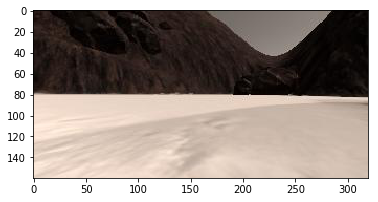

In [2]:
path = './test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

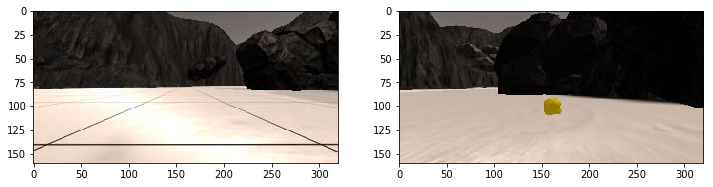

In [3]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = './calibration_images/example_grid1.jpg'
example_rock = './calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

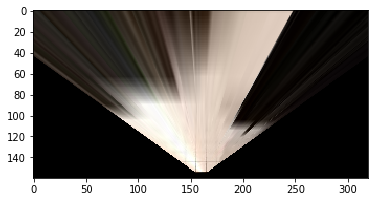

In [23]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function from the lesson and apply it to the warped image

**TODO:** Ultimately, you want your map to not just include navigable terrain but also obstacles and the positions of the rock samples you're searching for.  Modify this function or write a new function that returns the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that you can map these areas into world coordinates as well.  
**Suggestion:** Think about imposing a lower and upper boundary in your color selection to be more specific about choosing colors.  Feel free to get creative and even bring in functions from other libraries.  Here's an example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  
**Beware:** if you start manipulating images with OpenCV, keep in mind that it defaults to `BGR` instead of `RGB` color space when reading/writing images, so things can get confusing.

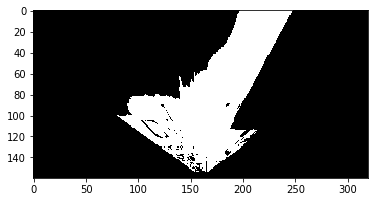

In [24]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh_low=(160, 160, 160), rgb_thresh_high=(255, 255, 255)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    pix = (img[:,:,0] > rgb_thresh_low[0]) & (img[:,:,0] < rgb_thresh_high[0])\
         & (img[:,:,1] > rgb_thresh_low[1]) & (img[:,:,1] < rgb_thresh_high[1]) \
         & (img[:,:,2] > rgb_thresh_low[2]) & (img[:,:,2] < rgb_thresh_high[2]) 
                
    # Index the array of zeros with the boolean array and set to 1
    color_select[pix] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

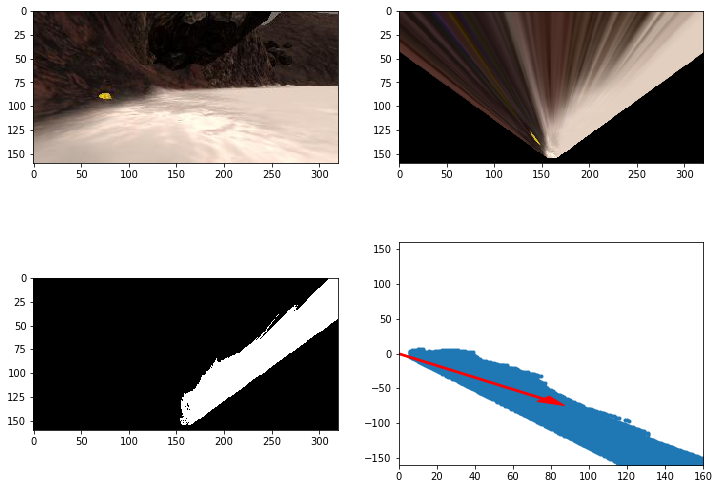

In [25]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to apply a rotation to pixel positions
def rotate_pix(xpix, ypix, yaw):
    # TODO:
    # Convert yaw to radians
    # Apply a rotation
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    ypix_rotated = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    
    # Return the result  
    return xpix_rotated, ypix_rotated

# Define a function to perform a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # TODO:
    # Apply a scaling and a translation
    xpix_translated = 0
    ypix_translated = 0
    
    xpix_translated = np.int_(xpos + (xpix_rot / scale))
    ypix_translated = np.int_(ypos + (ypix_rot / scale))
    # Return the result  
    return xpix_translated, ypix_translated

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)

threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [26]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change this path to your data directory
df = pd.read_csv('./test_dataset/robot_log.csv')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('./calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = -1 # This will be a running index, setting to -1 is a hack
                        # because moviepy (below) seems to run one extra iteration
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

Modify the `process_image()` function below by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the images you saved taking data in the simulator.  

In short, you will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of video.  You can make a mosaic of the various steps of your analysis process and add text as you like (example provided below).  



To start with, you can simply run the next three cells to see what happens, but then go ahead and modify them such that the output video demonstrates your mapping process.  Feel free to get creative!

In [32]:

# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # Use grid from the previous image
    dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    # this is just a rough guess, feel free to change it!
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
     
    # 2) Apply perspective transform
    warped = perspect_transform(img, source, destination)
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    navigable = color_thresh(warped, (160,160,160),(255,255,255))
    obstable  = color_thresh(warped, (0,0,0),(10,10,10))
    rock  = color_thresh(warped, (120,90,0),(230,200,70))
    
    # 4) Convert thresholded image pixel values to rover-centric coords
    navi_xpix, navi_ypix = rover_coords(navigable)
    obs_xpix, obs_ypix = rover_coords(obstable)
    rock_xpix, rock_ypix = rover_coords(rock)
    

    # 5) Convert rover-centric pixel values to world coords
    xpos = data.xpos[data.count]
    ypos = data.ypos[data.count]
    yaw =  data.yaw[data.count]
    
    print("current data count: {} --> xpos: {}, ypos: {}, yaw: {}".format(data.count, xpos, ypos, yaw))
    world_size = data.worldmap.shape[0]
    scale = 10
    
    navigable_x_world, navigable_y_world = pix_to_world(navi_xpix, navi_ypix, xpos, ypos, yaw, world_size, scale)
    obstacle_x_world, obstacle_y_world = pix_to_world(obs_xpix, obs_ypix, xpos, ypos, yaw, world_size, scale)
    rock_x_world, rock_y_world = pix_to_world(rock_xpix, rock_ypix, xpos, ypos, yaw, world_size, scale)
        
    # 6) Update worldmap (to be displayed on right side of screen)
    # Current position
    # Example: 
    data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
    data.worldmap[rock_y_world, rock_x_world, 1] += 1
    data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    #dist, angles = to_polar_coords(xpix, ypix)
    #mean_dir = np.mean(angles)
        
        
        
    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = './output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

current data count: -1 --> xpos: 132.2827, ypos: 104.8689, yaw: 36.71686
[MoviePy] >>>> Building video ./output/test_mapping.mp4
[MoviePy] Writing video ./output/test_mapping.mp4


  2%|▏         | 6/283 [00:00<00:04, 58.13it/s]

current data count: 0 --> xpos: 99.66999, ypos: 85.58896999999999, yaw: 56.82555
current data count: 1 --> xpos: 99.66999, ypos: 85.58896999999999, yaw: 56.82555
current data count: 2 --> xpos: 99.66999, ypos: 85.58896999999999, yaw: 56.82555
current data count: 3 --> xpos: 99.66999, ypos: 85.58896999999999, yaw: 56.82555
current data count: 4 --> xpos: 99.66999, ypos: 85.58896999999999, yaw: 56.82555
current data count: 5 --> xpos: 99.66999, ypos: 85.58896999999999, yaw: 56.82555
current data count: 6 --> xpos: 99.66999, ypos: 85.58896999999999, yaw: 56.82555
current data count: 7 --> xpos: 99.66999, ypos: 85.58896999999999, yaw: 56.82555
current data count: 8 --> xpos: 99.66999, ypos: 85.58896999999999, yaw: 56.82555
current data count: 9 --> xpos: 99.67065, ypos: 85.58999, yaw: 56.82556999999999
current data count: 10 --> xpos: 99.67067, ypos: 85.59003, yaw: 56.825419999999994
current data count: 11 --> xpos: 99.67067, ypos: 85.59003, yaw: 56.825419999999994
current data count: 12 -

  7%|▋         | 21/283 [00:00<00:04, 63.37it/s]

current data count: 13 --> xpos: 99.67066, ypos: 85.59003, yaw: 56.825419999999994
current data count: 14 --> xpos: 99.67065, ypos: 85.59003, yaw: 56.825419999999994
current data count: 15 --> xpos: 99.67065, ypos: 85.59003, yaw: 56.82541
current data count: 16 --> xpos: 99.67064, ypos: 85.59003, yaw: 56.82541
current data count: 17 --> xpos: 99.67064, ypos: 85.59003, yaw: 56.82541
current data count: 18 --> xpos: 99.67063, ypos: 85.59003, yaw: 56.82541
current data count: 19 --> xpos: 99.67062, ypos: 85.59003, yaw: 56.82541
current data count: 20 --> xpos: 99.67062, ypos: 85.59003, yaw: 56.82541
current data count: 21 --> xpos: 99.67062, ypos: 85.59004, yaw: 56.8254
current data count: 22 --> xpos: 99.67062, ypos: 85.59005, yaw: 56.8254
current data count: 23 --> xpos: 99.67062, ypos: 85.59005, yaw: 56.8254
current data count: 24 --> xpos: 99.6708, ypos: 85.59031999999999, yaw: 56.82637
current data count: 25 --> xpos: 99.67083000000001, ypos: 85.59038000000001, yaw: 56.81548000000001

 13%|█▎        | 36/283 [00:00<00:03, 67.61it/s]

current data count: 28 --> xpos: 99.67529, ypos: 85.59719, yaw: 56.69259
current data count: 29 --> xpos: 99.67777, ypos: 85.60096, yaw: 56.73291
current data count: 30 --> xpos: 99.68341, ypos: 85.6096, yaw: 56.871809999999996
current data count: 31 --> xpos: 99.68764, ypos: 85.61605, yaw: 56.75683000000001
current data count: 32 --> xpos: 99.69625, ypos: 85.62921999999999, yaw: 56.750859999999996
current data count: 33 --> xpos: 99.70283, ypos: 85.63936, yaw: 56.889109999999995
current data count: 34 --> xpos: 99.71024, ypos: 85.65078000000001, yaw: 56.9262
current data count: 35 --> xpos: 99.71786999999999, ypos: 85.66252, yaw: 56.97526
current data count: 36 --> xpos: 99.72574, ypos: 85.67455, yaw: 57.014480000000006
current data count: 37 --> xpos: 99.73706999999999, ypos: 85.69167, yaw: 56.986019999999996
current data count: 38 --> xpos: 99.74576, ypos: 85.70506, yaw: 56.935390000000005
current data count: 39 --> xpos: 99.76088, ypos: 85.72845, yaw: 56.8792
current data count: 40

 17%|█▋        | 49/283 [00:00<00:04, 58.26it/s]

current data count: 42 --> xpos: 99.81023, ypos: 85.8047, yaw: 56.835519999999995
current data count: 43 --> xpos: 99.83139, ypos: 85.83752, yaw: 56.96938000000001
current data count: 44 --> xpos: 99.84605, ypos: 85.86028, yaw: 57.063869999999994
current data count: 45 --> xpos: 99.86151, ypos: 85.88438000000001, yaw: 57.10579
current data count: 46 --> xpos: 99.87763000000001, ypos: 85.90944, yaw: 57.08944
current data count: 47 --> xpos: 99.90364, ypos: 85.94996, yaw: 57.10592
current data count: 48 --> xpos: 99.92182, ypos: 85.9783, yaw: 57.13094
current data count: 49 --> xpos: 99.95082, ypos: 86.02351, yaw: 57.156780000000005
current data count: 50 --> xpos: 99.97074, ypos: 86.05458, yaw: 57.21354
current data count: 51 --> xpos: 99.99143000000001, ypos: 86.08694, yaw: 57.22939


 19%|█▉        | 55/283 [00:00<00:04, 54.03it/s]

current data count: 52 --> xpos: 100.0236, ypos: 86.13731, yaw: 57.23721
current data count: 53 --> xpos: 100.0459, ypos: 86.17214, yaw: 57.2653
current data count: 54 --> xpos: 100.0807, ypos: 86.22678, yaw: 57.22249
current data count: 55 --> xpos: 100.1048, ypos: 86.26463000000001, yaw: 57.227819999999994
current data count: 56 --> xpos: 100.1422, ypos: 86.32311999999999, yaw: 57.256009999999996
current data count: 57 --> xpos: 100.1679, ypos: 86.36343000000001, yaw: 57.274930000000005
current data count: 58 --> xpos: 100.2078, ypos: 86.42599, yaw: 57.31474


 22%|██▏       | 61/283 [00:01<00:04, 51.21it/s]

current data count: 59 --> xpos: 100.2352, ypos: 86.469, yaw: 57.33373
current data count: 60 --> xpos: 100.2775, ypos: 86.53555, yaw: 57.359790000000004
current data count: 61 --> xpos: 100.3065, ypos: 86.58121, yaw: 57.36985


 24%|██▎       | 67/283 [00:01<00:04, 52.92it/s]

current data count: 62 --> xpos: 100.3362, ypos: 86.62803000000001, yaw: 57.3862
current data count: 63 --> xpos: 100.382, ypos: 86.7002, yaw: 57.402919999999995
current data count: 64 --> xpos: 100.4134, ypos: 86.7497, yaw: 57.41326
current data count: 65 --> xpos: 100.4454, ypos: 86.80023, yaw: 57.42235
current data count: 66 --> xpos: 100.4947, ypos: 86.87801, yaw: 57.43326999999999
current data count: 67 --> xpos: 100.5284, ypos: 86.93118, yaw: 57.441309999999994
current data count: 68 --> xpos: 100.5801, ypos: 87.0129, yaw: 57.45065
current data count: 69 --> xpos: 100.6154, ypos: 87.06869, yaw: 57.4585
current data count: 70 --> xpos: 100.6696, ypos: 87.15439, yaw: 57.46998000000001
current data count: 71 --> xpos: 100.7065, ypos: 87.21281, yaw: 57.47704
current data count: 72 --> xpos: 100.7441, ypos: 87.27225, yaw: 57.484230000000004


 28%|██▊       | 79/283 [00:01<00:04, 48.84it/s]

current data count: 73 --> xpos: 100.8016, ypos: 87.36334000000001, yaw: 57.496230000000004
current data count: 74 --> xpos: 100.8408, ypos: 87.42538, yaw: 57.5027
current data count: 75 --> xpos: 100.9008, ypos: 87.52039, yaw: 57.5137
current data count: 76 --> xpos: 100.9416, ypos: 87.58498, yaw: 57.520869999999995
current data count: 77 --> xpos: 100.98299999999999, ypos: 87.65063, yaw: 57.52985
current data count: 78 --> xpos: 101.0463, ypos: 87.75102, yaw: 57.540659999999995
current data count: 79 --> xpos: 101.0892, ypos: 87.81926, yaw: 57.5657
current data count: 80 --> xpos: 101.1536, ypos: 87.92416, yaw: 57.835409999999996
current data count: 81 --> xpos: 101.1962, ypos: 87.99583, yaw: 58.207919999999994


 30%|██▉       | 84/283 [00:01<00:04, 45.87it/s]

current data count: 82 --> xpos: 101.2594, ypos: 88.10625999999999, yaw: 59.00399
current data count: 83 --> xpos: 101.3006, ypos: 88.18200999999999, yaw: 59.70157
current data count: 84 --> xpos: 101.3412, ypos: 88.25932, yaw: 60.47002
current data count: 85 --> xpos: 101.4032, ypos: 88.37705, yaw: 61.36253000000001
current data count: 86 --> xpos: 101.4455, ypos: 88.45683000000001, yaw: 61.73438
current data count: 87 --> xpos: 101.4889, ypos: 88.53773000000001, yaw: 61.90596


 31%|███▏      | 89/283 [00:01<00:04, 44.74it/s]

current data count: 88 --> xpos: 101.5549, ypos: 88.66154, yaw: 61.974869999999996
current data count: 89 --> xpos: 101.5995, ypos: 88.74553, yaw: 61.989180000000005
current data count: 90 --> xpos: 101.6669, ypos: 88.87303, yaw: 62.00551


 33%|███▎      | 94/283 [00:01<00:04, 44.55it/s]

current data count: 91 --> xpos: 101.7122, ypos: 88.95907, yaw: 62.01611
current data count: 92 --> xpos: 101.7581, ypos: 89.0461, yaw: 62.02626
current data count: 93 --> xpos: 101.8279, ypos: 89.17898000000001, yaw: 62.0603
current data count: 94 --> xpos: 101.8742, ypos: 89.26921, yaw: 62.24748
current data count: 95 --> xpos: 101.92, ypos: 89.36086, yaw: 62.61549
current data count: 96 --> xpos: 101.9889, ypos: 89.50081, yaw: 63.19849
current data count: 97 --> xpos: 102.0354, ypos: 89.59543000000001, yaw: 63.45715

 35%|███▍      | 99/283 [00:01<00:04, 44.58it/s]


current data count: 98 --> xpos: 102.1059, ypos: 89.7394, yaw: 63.721019999999996
current data count: 99 --> xpos: 102.1525, ypos: 89.83711, yaw: 64.00562


 37%|███▋      | 104/283 [00:02<00:04, 44.03it/s]

current data count: 100 --> xpos: 102.1983, ypos: 89.93626, yaw: 64.45742
current data count: 101 --> xpos: 102.2668, ypos: 90.0874, yaw: 65.16776
current data count: 102 --> xpos: 102.3126, ypos: 90.1897, yaw: 65.52991
current data count: 103 --> xpos: 102.3819, ypos: 90.34528, yaw: 65.91586
current data count: 104 --> xpos: 102.4286, ypos: 90.45034, yaw: 66.03239
current data count: 105 --> xpos: 102.4752, ypos: 90.55662, yaw: 66.20061


 39%|███▊      | 109/283 [00:02<00:04, 43.41it/s]

current data count: 106 --> xpos: 102.5432, ypos: 90.71885, yaw: 66.8178
current data count: 107 --> xpos: 102.5876, ypos: 90.82874, yaw: 67.36688000000001
current data count: 108 --> xpos: 102.6548, ypos: 90.99569, yaw: 67.95786


 40%|████      | 114/283 [00:02<00:03, 43.18it/s]

current data count: 109 --> xpos: 102.6999, ypos: 91.10857, yaw: 68.22184
current data count: 110 --> xpos: 102.766, ypos: 91.28044, yaw: 68.80521999999999
current data count: 111 --> xpos: 102.8079, ypos: 91.39690999999999, yaw: 69.4617
current data count: 112 --> xpos: 102.8484, ypos: 91.51441, yaw: 70.25198
current data count: 113 --> xpos: 102.90700000000001, ypos: 91.69287, yaw: 71.47055
current data count: 114 --> xpos: 102.9441, ypos: 91.81376999999999, yaw: 72.28815999999999
current data count: 115 --> xpos: 102.9981, ypos: 91.99757, yaw: 73.38407
current data count: 116 --> xpos: 103.0315, ypos: 92.12179, yaw: 74.25146
current data count: 117 --> xpos: 103.0779, ypos: 92.3102, yaw: 75.75044


 44%|████▍     | 124/283 [00:02<00:03, 42.70it/s]

current data count: 118 --> xpos: 103.1073, ypos: 92.43719, yaw: 76.63359
current data count: 119 --> xpos: 103.1502, ypos: 92.63037, yaw: 77.56241
current data count: 120 --> xpos: 103.1788, ypos: 92.76096, yaw: 77.88167
current data count: 121 --> xpos: 103.2078, ypos: 92.89313, yaw: 78.01364000000001
current data count: 122 --> xpos: 103.2514, ypos: 93.09423000000001, yaw: 78.07328000000001
current data count: 123 --> xpos: 103.2809, ypos: 93.23, yaw: 78.0602
current data count: 124 --> xpos: 103.3109, ypos: 93.3671, yaw: 78.00909
current data count: 125 --> xpos: 103.3565, ypos: 93.57526, yaw: 77.91139
current data count: 126 --> xpos: 103.3872, ypos: 93.71566999999999, yaw: 77.87611


 46%|████▌     | 129/283 [00:02<00:03, 42.44it/s]

current data count: 127 --> xpos: 103.4181, ypos: 93.85728, yaw: 77.85344
current data count: 128 --> xpos: 103.465, ypos: 94.07202, yaw: 77.82884
current data count: 129 --> xpos: 103.4968, ypos: 94.21663000000001, yaw: 77.79743
current data count: 130 --> xpos: 103.5464, ypos: 94.43549, yaw: 77.56206999999999
current data count: 131 --> xpos: 103.5813, ypos: 94.58248, yaw: 77.24284
current data count: 132 --> xpos: 103.6179, ypos: 94.7302, yaw: 76.78392


 47%|████▋     | 134/283 [00:02<00:03, 42.41it/s]

current data count: 133 --> xpos: 103.6753, ypos: 94.95196, yaw: 75.7267
current data count: 134 --> xpos: 103.7159, ypos: 95.09849, yaw: 74.72603000000001
current data count: 135 --> xpos: 103.7826, ypos: 95.31466, yaw: 72.68961


 49%|████▉     | 139/283 [00:02<00:03, 42.26it/s]

current data count: 136 --> xpos: 103.8311, ypos: 95.45625, yaw: 71.1333
current data count: 137 --> xpos: 103.8835, ypos: 95.59643, yaw: 69.47205
current data count: 138 --> xpos: 103.9723, ypos: 95.80537, yaw: 67.06825
current data count: 139 --> xpos: 104.0359, ypos: 95.94311, yaw: 65.52441999999999
current data count: 140 --> xpos: 104.1021, ypos: 96.0809, yaw: 64.05154
current data count: 141 --> xpos: 104.2066, ypos: 96.28983000000001, yaw: 62.065940000000005


 51%|█████     | 144/283 [00:02<00:03, 41.87it/s]

current data count: 142 --> xpos: 104.2803, ypos: 96.42988000000001, yaw: 60.780080000000005
current data count: 143 --> xpos: 104.4, ypos: 96.63942, yaw: 58.65003000000001
current data count: 144 --> xpos: 104.4846, ypos: 96.7762, yaw: 57.1133


 53%|█████▎    | 149/283 [00:03<00:03, 41.70it/s]

current data count: 145 --> xpos: 104.574, ypos: 96.90939, yaw: 55.41125
current data count: 146 --> xpos: 104.71799999999999, ypos: 97.10325999999999, yaw: 52.96165
current data count: 147 --> xpos: 104.8186, ypos: 97.23083000000001, yaw: 51.45167
current data count: 148 --> xpos: 104.9224, ypos: 97.35765, yaw: 50.0022
current data count: 149 --> xpos: 105.0851, ypos: 97.54298, yaw: 47.7893
current data count: 150 --> xpos: 105.1978, ypos: 97.6636, yaw: 46.28237
current data count: 151 --> xpos: 105.3751, ypos: 97.83971, yaw: 44.04572
current data count: 152 --> xpos: 105.4971, ypos: 97.95413, yaw: 42.55407
current data count: 153 --> xpos: 105.6225, ypos: 98.06591, yaw: 41.06266


 56%|█████▌    | 159/283 [00:03<00:02, 41.78it/s]

current data count: 154 --> xpos: 105.7513, ypos: 98.17452, yaw: 39.58194
current data count: 155 --> xpos: 105.9511, ypos: 98.33268000000001, yaw: 37.37595
current data count: 156 --> xpos: 106.0881, ypos: 98.43437, yaw: 35.897040000000004
current data count: 157 --> xpos: 106.2282, ypos: 98.53296999999999, yaw: 34.41616
current data count: 158 --> xpos: 106.4444, ypos: 98.67451, yaw: 32.218790000000006
current data count: 159 --> xpos: 106.59200000000001, ypos: 98.76510999999999, yaw: 30.74901
current data count: 160 --> xpos: 106.7424, ypos: 98.85236, yaw: 29.266609999999996
current data count: 161 --> xpos: 106.9736, ypos: 98.9761, yaw: 27.0724
current data count: 162 --> xpos: 107.1309, ypos: 99.05443000000001, yaw: 25.60793


 58%|█████▊    | 164/283 [00:03<00:02, 39.91it/s]

current data count: 163 --> xpos: 107.2907, ypos: 99.12914, yaw: 24.13171
current data count: 164 --> xpos: 107.45299999999999, ypos: 99.19995, yaw: 22.658070000000002
current data count: 165 --> xpos: 107.7011, ypos: 99.29843000000001, yaw: 20.4811
current data count: 166 --> xpos: 107.8691, ypos: 99.35991999999999, yaw: 19.043879999999998
current data count: 167 --> xpos: 108.039, ypos: 99.41705, yaw: 17.58406


 60%|█████▉    | 169/283 [00:03<00:02, 39.25it/s]

current data count: 168 --> xpos: 108.2115, ypos: 99.47005, yaw: 16.13737
current data count: 169 --> xpos: 108.4734, ypos: 99.54164, yaw: 13.96394
current data count: 170 --> xpos: 108.6505, ypos: 99.58436999999999, yaw: 12.543460000000001


 61%|██████    | 173/283 [00:03<00:02, 38.72it/s]

current data count: 171 --> xpos: 108.8291, ypos: 99.62321999999999, yaw: 11.10295
current data count: 172 --> xpos: 109.1, ypos: 99.67268, yaw: 8.941550999999999
current data count: 173 --> xpos: 109.2824, ypos: 99.70014, yaw: 7.503280999999999
current data count: 174 --> xpos: 109.4658, ypos: 99.72329, yaw: 6.06736
current data count: 175 --> xpos: 109.6512, ypos: 99.7411, yaw: 4.633476


 63%|██████▎   | 177/283 [00:03<00:02, 38.80it/s]

current data count: 176 --> xpos: 109.8367, ypos: 99.7557, yaw: 3.278915
current data count: 177 --> xpos: 110.1172, ypos: 99.77056, yaw: 1.210754
current data count: 178 --> xpos: 110.305, ypos: 99.773, yaw: 359.7514


 64%|██████▍   | 181/283 [00:03<00:02, 38.34it/s]

current data count: 179 --> xpos: 110.4939, ypos: 99.77105999999999, yaw: 358.3399
current data count: 180 --> xpos: 110.7779, ypos: 99.76071999999999, yaw: 356.2529
current data count: 181 --> xpos: 110.9682, ypos: 99.7477, yaw: 354.8669
current data count: 182 --> xpos: 111.1586, ypos: 99.73002, yaw: 353.4712
current data count: 183 --> xpos: 111.4444, ypos: 99.69476, yaw: 351.37699999999995


 65%|██████▌   | 185/283 [00:04<00:02, 38.07it/s]

current data count: 184 --> xpos: 111.6347, ypos: 99.66462, yaw: 349.9948
current data count: 185 --> xpos: 111.9206, ypos: 99.61458, yaw: 348.0704
current data count: 186 --> xpos: 112.1109, ypos: 99.57439000000001, yaw: 346.7065


 67%|██████▋   | 189/283 [00:04<00:02, 38.11it/s]

current data count: 187 --> xpos: 112.3008, ypos: 99.52911999999999, yaw: 345.4606
current data count: 188 --> xpos: 112.5858, ypos: 99.45514, yaw: 343.9397
current data count: 189 --> xpos: 112.77600000000001, ypos: 99.40215, yaw: 343.1592
current data count: 190 --> xpos: 112.9664, ypos: 99.34651, yaw: 342.5939
current data count: 191 --> xpos: 113.1575, ypos: 99.28871, yaw: 342.2404


 68%|██████▊   | 193/283 [00:04<00:02, 37.48it/s]

current data count: 192 --> xpos: 113.4448, ypos: 99.19936, yaw: 341.9935
current data count: 193 --> xpos: 113.6363, ypos: 99.13851, yaw: 341.921
current data count: 194 --> xpos: 113.82799999999999, ypos: 99.07708000000001, yaw: 341.8993


 70%|██████▉   | 197/283 [00:04<00:02, 37.34it/s]

current data count: 195 --> xpos: 114.02, ypos: 99.01573, yaw: 341.9667
current data count: 196 --> xpos: 114.3093, ypos: 98.92374000000001, yaw: 342.1723
current data count: 197 --> xpos: 114.5023, ypos: 98.86247, yaw: 342.2795
current data count: 198 --> xpos: 114.7918, ypos: 98.77076, yaw: 342.3696
current data count: 199 --> xpos: 114.9853, ypos: 98.70954, yaw: 342.4014


 71%|███████   | 201/283 [00:04<00:02, 37.94it/s]

current data count: 200 --> xpos: 115.179, ypos: 98.64849, yaw: 342.4269
current data count: 201 --> xpos: 115.3727, ypos: 98.58759, yaw: 342.4516
current data count: 202 --> xpos: 115.5666, ypos: 98.52696999999999, yaw: 342.4971


 72%|███████▏  | 205/283 [00:04<00:02, 37.62it/s]

current data count: 203 --> xpos: 115.7608, ypos: 98.46669, yaw: 342.5748
current data count: 204 --> xpos: 116.0503, ypos: 98.37451999999999, yaw: 342.6274
current data count: 205 --> xpos: 116.3369, ypos: 98.28401, yaw: 342.8096
current data count: 206 --> xpos: 116.5242, ypos: 98.22676, yaw: 343.0958
current data count: 207 --> xpos: 116.8111, ypos: 98.14166999999999, yaw: 343.61199999999997


 74%|███████▍  | 209/283 [00:04<00:02, 36.77it/s]

current data count: 208 --> xpos: 117.0034, ypos: 98.08728, yaw: 344.1548
current data count: 209 --> xpos: 117.2933, ypos: 98.01138, yaw: 345.3754
current data count: 210 --> xpos: 117.4871, ypos: 97.96483, yaw: 346.48900000000003


 75%|███████▌  | 213/283 [00:04<00:01, 36.54it/s]

current data count: 211 --> xpos: 117.68, ypos: 97.92097, yaw: 347.7763
current data count: 212 --> xpos: 117.9688, ypos: 97.86288, yaw: 349.9061
current data count: 213 --> xpos: 118.2582, ypos: 97.81596, yaw: 352.0687
current data count: 214 --> xpos: 118.45100000000001, ypos: 97.79037, yaw: 353.4961
current data count: 215 --> xpos: 118.7448, ypos: 97.75539, yaw: 355.3194


 77%|███████▋  | 217/283 [00:04<00:01, 36.71it/s]

current data count: 216 --> xpos: 118.9432, ypos: 97.73549, yaw: 356.4568
current data count: 217 --> xpos: 119.1435, ypos: 97.71902, yaw: 357.5864
current data count: 218 --> xpos: 119.3457, ypos: 97.70633000000001, yaw: 358.7256


 78%|███████▊  | 221/283 [00:05<00:01, 34.78it/s]

current data count: 219 --> xpos: 119.648, ypos: 97.69699, yaw: 0.8769455
current data count: 220 --> xpos: 119.8473, ypos: 97.69925, yaw: 2.5557939999999997
current data count: 221 --> xpos: 120.0456, ypos: 97.70815, yaw: 4.288055
current data count: 222 --> xpos: 120.3433, ypos: 97.73219, yaw: 6.678909


 80%|███████▉  | 225/283 [00:05<00:01, 35.20it/s]

current data count: 223 --> xpos: 120.542, ypos: 97.75455, yaw: 8.117653
current data count: 224 --> xpos: 120.7399, ypos: 97.77977, yaw: 9.417999
current data count: 225 --> xpos: 120.9374, ypos: 97.80843, yaw: 10.63303
current data count: 226 --> xpos: 121.2334, ypos: 97.86036, yaw: 12.521930000000001


 81%|████████  | 229/283 [00:05<00:01, 35.72it/s]

current data count: 227 --> xpos: 121.5259, ypos: 97.92715, yaw: 14.458120000000001
current data count: 228 --> xpos: 121.7197, ypos: 97.97586, yaw: 15.49172
current data count: 229 --> xpos: 121.9125, ypos: 98.02778, yaw: 16.43674
current data count: 230 --> xpos: 122.2004, ypos: 98.11415, yaw: 17.99342
current data count: 231 --> xpos: 122.4851, ypos: 98.20723000000001, yaw: 19.69685

 82%|████████▏ | 233/283 [00:05<00:01, 36.73it/s]


current data count: 232 --> xpos: 122.6679, ypos: 98.27457, yaw: 20.50404
current data count: 233 --> xpos: 122.9464, ypos: 98.37931999999999, yaw: 21.88113
current data count: 234 --> xpos: 123.1339, ypos: 98.45393, yaw: 22.860960000000002


 84%|████████▎ | 237/283 [00:05<00:01, 37.62it/s]

current data count: 235 --> xpos: 123.3191, ypos: 98.53586, yaw: 23.84947
current data count: 236 --> xpos: 123.5918, ypos: 98.65934, yaw: 25.45441
current data count: 237 --> xpos: 123.7709, ypos: 98.74324, yaw: 26.6628
current data count: 238 --> xpos: 124.0329, ypos: 98.87938, yaw: 28.763709999999996
current data count: 239 --> xpos: 124.1952, ypos: 98.97771999999999, yaw: 29.874859999999998


 86%|████████▌ | 242/283 [00:05<00:01, 38.92it/s]

current data count: 240 --> xpos: 124.4504, ypos: 99.12666999999999, yaw: 31.321040000000004
current data count: 241 --> xpos: 124.61399999999999, ypos: 99.23376, yaw: 32.67917
current data count: 242 --> xpos: 124.7715, ypos: 99.34522, yaw: 33.98572
current data count: 243 --> xpos: 124.9258, ypos: 99.45914, yaw: 35.33546


 87%|████████▋ | 246/283 [00:05<00:00, 38.13it/s]

current data count: 244 --> xpos: 125.1665, ypos: 99.63172, yaw: 36.4525
current data count: 245 --> xpos: 125.3292, ypos: 99.75147, yaw: 36.59858
current data count: 246 --> xpos: 125.4924, ypos: 99.87868, yaw: 36.60537
current data count: 247 --> xpos: 125.6582, ypos: 100.001, yaw: 36.472559999999994


 89%|████████▊ | 251/283 [00:05<00:00, 39.04it/s]

current data count: 248 --> xpos: 125.9136, ypos: 100.1793, yaw: 36.05021
current data count: 249 --> xpos: 126.0835, ypos: 100.2951, yaw: 35.717859999999995
current data count: 250 --> xpos: 126.2527, ypos: 100.4088, yaw: 35.3788
current data count: 251 --> xpos: 126.5056, ypos: 100.5756, yaw: 34.86925
current data count: 252 --> xpos: 126.6739, ypos: 100.6847, yaw: 34.629059999999996


 90%|█████████ | 255/283 [00:05<00:00, 39.09it/s]

current data count: 253 --> xpos: 126.9228, ypos: 100.8546, yaw: 35.0514
current data count: 254 --> xpos: 127.083, ypos: 100.9712, yaw: 35.31912
current data count: 255 --> xpos: 127.2413, ypos: 101.0884, yaw: 35.536559999999994
current data count: 256 --> xpos: 127.3975, ypos: 101.2065, yaw: 35.790440000000004


 92%|█████████▏| 259/283 [00:05<00:00, 38.52it/s]

current data count: 257 --> xpos: 127.6294, ypos: 101.3862, yaw: 36.269659999999995
current data count: 258 --> xpos: 127.7847, ypos: 101.5091, yaw: 36.647420000000004
current data count: 259 --> xpos: 127.9421, ypos: 101.6341, yaw: 36.92297
current data count: 260 --> xpos: 128.1833, ypos: 101.8206, yaw: 36.978359999999995


 93%|█████████▎| 263/283 [00:06<00:00, 38.75it/s]

current data count: 261 --> xpos: 128.3457, ypos: 101.9434, yaw: 36.95173
current data count: 262 --> xpos: 128.59, ypos: 102.1269, yaw: 36.93332
current data count: 263 --> xpos: 128.7528, ypos: 102.2479, yaw: 36.91267
current data count: 264 --> xpos: 128.9153, ypos: 102.3684, yaw: 36.89141


 94%|█████████▍| 267/283 [00:06<00:00, 37.34it/s]

current data count: 265 --> xpos: 129.1584, ypos: 102.5483, yaw: 36.85944
current data count: 266 --> xpos: 129.3197, ypos: 102.6672, yaw: 36.84244
current data count: 267 --> xpos: 129.5601, ypos: 102.8436, yaw: 36.82764
current data count: 268 --> xpos: 129.719, ypos: 102.9611, yaw: 36.81414


 96%|█████████▌| 271/283 [00:06<00:00, 37.53it/s]

current data count: 269 --> xpos: 129.8772, ypos: 103.0783, yaw: 36.8014
current data count: 270 --> xpos: 130.1134, ypos: 103.2535, yaw: 36.78523
current data count: 271 --> xpos: 130.2701, ypos: 103.37, yaw: 36.77633
current data count: 272 --> xpos: 130.5043, ypos: 103.5443, yaw: 36.767340000000004


 97%|█████████▋| 275/283 [00:06<00:00, 38.24it/s]

current data count: 273 --> xpos: 130.6604, ypos: 103.6601, yaw: 36.75521
current data count: 274 --> xpos: 130.8163, ypos: 103.7758, yaw: 36.7399
current data count: 275 --> xpos: 131.0498, ypos: 103.949, yaw: 36.718109999999996
current data count: 276 --> xpos: 131.2048, ypos: 104.0645, yaw: 36.71013
current data count: 277 --> xpos: 131.3598, ypos: 104.1796, yaw: 36.6977

 99%|█████████▊| 279/283 [00:06<00:00, 38.03it/s]


current data count: 278 --> xpos: 131.5917, ypos: 104.3521, yaw: 36.684540000000005
current data count: 279 --> xpos: 131.7457, ypos: 104.4669, yaw: 36.68127
current data count: 280 --> xpos: 131.9761, ypos: 104.6394, yaw: 36.694320000000005


100%|██████████| 283/283 [00:06<00:00, 38.55it/s]

current data count: 281 --> xpos: 132.1295, ypos: 104.7544, yaw: 36.7089
current data count: 282 --> xpos: 132.2827, ypos: 104.8689, yaw: 36.71686


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output/test_mapping.mp4 

CPU times: user 3.3 s, sys: 106 ms, total: 3.4 s
Wall time: 7.09 s


### This next cell should function as an inline video player
If this fails to render the video, try running the following cell (alternative video rendering method).  You can also simply have a look at the saved mp4 in your `/output` folder

In [ ]:
output = './output/test_mapping.mp4'
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))